In [1]:
import tensorflow as tf
import DataLoader
import model
from model import MyModel1

2.2.0-dev20200307


In [2]:
import datetime

In [3]:
import os
import SimpleITK as sitk
import numpy as np
import pydicom

In [4]:
import matplotlib.pyplot as plt
import cv2

In [5]:
from tensorflow.keras import layers
from imgaug import augmenters as iaa

In [6]:
from config import Config

In [7]:
import pydot 
pydot.find_graphviz = lambda: True 
from tensorflow.keras.utils import plot_model 

In [8]:
train_dir = "/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaData/20191108_41对/train"
val_dir = "/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaData/20191108_41对/val"
test_dir = "/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaData/20191108_41对/test"
csv_path = "/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaData/20191108_41对/df.csv"

dataset_train = DataLoader.Dataset()
dataset_test = DataLoader.Dataset()
dataset_val = DataLoader.Dataset()

dataset_train.load_dataset(train_dir)
dataset_test.load_dataset(test_dir)
dataset_val.load_dataset(val_dir)

/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaData/20191108_41对/train
/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaData/20191108_41对/test
/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaData/20191108_41对/val


In [9]:
#dataset_val = DataLoader.Dataset()
#dataset_val.load_dataset(val_dir)

In [10]:
augment = iaa.SomeOf((0, 2), [iaa.Fliplr(0.5),
                                   iaa.Flipud(0.5),
                                   iaa.OneOf([iaa.Affine(rotate=90),
                                              iaa.Affine(rotate=180),
                                              iaa.Affine(rotate=270)])])
        #iaa.Multiply((0.8, 1.5)),
        #iaa.Invert(1,per_channel=True,max_value=65535)
       # iaa.GaussianBlur(sigma=(0.0, 5.0))
    

In [11]:
case_i=dataset_train.load_case(dataset_train.case_id[0], csv_path)

In [12]:
case_i[0].shape

(18,)

In [50]:
print(np.max(im))

255


In [51]:
#img_id = 1

dataset_train.case_id

In [11]:
def train_generator():
    #assert isinstance(dataset, Dataset), "dadaset is not belong to Dataset class"
    for i in dataset_train.case_id:
        img, class_id = dataset_train.load_case_image(i, IMG_ID)
        det = augment.to_deterministic()
        img = det.augment_image(img)
        yield img, class_id


In [12]:
def test_generator():
    #assert isinstance(dataset, Dataset), "dadaset is not belong to Dataset class"
    for i in dataset_test.case_id:
        img, class_id = dataset_test.load_case_image(i, IMG_ID)[0]
        yield img, class_id

def val_generator(augment=False):
    #assert isinstance(dataset, Dataset), "dadaset is not belong to Dataset class"
    for i in dataset_val.image_id:
        img, class_id = dataset_val.load_image(i)
        yield img, class_id



In [13]:
case_id=dataset_train.case_id[1]

In [11]:
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

In [ ]:
print()

In [15]:
df=pd.read_csv("/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaData/20191108_41对/df.csv", header=0)

df.drop(["tchol",'hdl','ldl','trig','hypotension'], axis=1, inplace=True)
df['ane_diam'].fillna(0,inplace=True)
df.fillna(method='ffill',inplace=True)
small = LabelBinarizer().fit(df["smallbin"])
df['smallbin']=small.transform(df['smallbin'])
dia = LabelBinarizer().fit(df["diabetes"])
hbp = LabelBinarizer().fit(df["HBP"])
df['diabetes']=dia.transform(df['diabetes'])
df['HBP']=hbp.transform(df['HBP'])
cs = MinMaxScaler()
df[df.columns[2:]] = cs.fit_transform(df[df.columns[2:]])
df[df.columns[2:]] = df[df.columns[2:]].astype(np.float32)
print(df)

    id  group  sex       age    score2  smallbin       bmi  time_onset  \
0    1      1  0.0  0.914894  0.586582       1.0  0.246592    0.009036   
1    1      0  0.0  0.872340  0.720968       1.0  0.459098    0.132530   
2    2      1  1.0  0.106383  0.128921       0.0  0.364911    0.024096   
3    2      0  1.0  0.000000  0.153463       0.0  0.525194    0.018072   
4    3      0  1.0  0.468085  0.511229       0.0  0.299540    0.493976   
5    3      1  1.0  0.446809  0.532517       1.0  0.451776    0.060241   
6    4      0  1.0  0.404255  0.232390       0.0  1.000000    0.003012   
7    4      1  1.0  0.531915  0.232192       1.0  0.104733    0.060241   
8    5      1  1.0  0.468085  0.804762       0.0  0.615205    0.060241   
9    5      0  1.0  0.468085  0.800563       0.0  0.410244    0.012048   
10   6      0  1.0  0.382979  0.149044       0.0  0.540006    0.000000   
11   6      1  1.0  0.468085  0.144864       0.0  0.314584    0.060241   
12   7      0  1.0  0.531915  0.193367

In [71]:
cid, group = case_id.split("_")
attribute = df[df.columns[2:]][(df['id']==int(cid))&(df['group']==1)] if group=='event' else df[(df['id']==int(cid))&(df['group']==0)]
print(attribute)
print(np.array(attribute))
print(np.array(attribute).shape)

    sex       age    score2  smallbin       bmi  time_onset  ane_diam  \
39  1.0  0.340426  0.195975       0.0  0.363675    0.060241       0.0   

    diabetes  hs_cad  hyperlipidemia  HBP       SBP       DBP  ECG  \
39       0.0     0.0             0.0  1.0  0.285714  0.381579  1.0   

    kidney_failure  ln_ddimer  limb_ischemia  tamponade_presurgbin  
39             0.0   0.431736            0.0                   0.0  
[[1.         0.34042552 0.19597453 0.         0.36367512 0.06024097
  0.         0.         0.         0.         1.         0.2857143
  0.38157895 1.         0.         0.43173632 0.         0.        ]]
(1, 18)


val_dataset = tf.data.Dataset.from_generator(
    val_generator, (tf.float32, tf.int8), (tf.TensorShape([512, 512, 3]),tf.TensorShape([])))

In [17]:
len(dataset_train.case_id)

49

In [18]:


#train_dataset = train_dataset.make_one_shot_iterator()
#_, labels = train_dataset.get_next()


## model0

In [13]:
for i in range(14):
    IMG_ID = i+1
    train_dataset = tf.data.Dataset.from_generator(
        train_generator, (tf.float32, tf.int8), 
        (tf.TensorShape([Config.IMAGE_DIM, Config.IMAGE_DIM, 3]), tf.TensorShape([])))

    train_dataset = train_dataset.shuffle(buffer_size=len(dataset_train.case_id))
    train_dataset = train_dataset.batch(1)
    
    now = datetime.datetime.now()
    model_dir = os.path.join('/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaPy/weights','{}'.format(i+1))
    log_dir = os.path.join(model_dir, "{:%Y%m%dT%H%M}".format(now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
    checkpoint_path = os.path.join(log_dir, "aorta_*epoch*.h5")
    checkpoint_path = checkpoint_path.replace("*epoch*", "{epoch:04d}")

    callbacks_list = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            verbose=0, save_weights_only=True),
    ]
    model = MyModel1(1)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    model.fit(train_dataset, epochs=20)#validation_data=test_dataset
    model.summary()

Epoch 1/20
81/81 [==============================] - 383s 5s/step - loss: nan - accuracy: 0.4938
Epoch 2/20
81/81 [==============================] - 359s 4s/step - loss: nan - accuracy: 0.4938
Epoch 3/20
 6/81 [=>............................] - ETA: 4:30 - loss: nan - accuracy: 0.6667

KeyboardInterrupt: 

In [24]:
for i in range(14):
    IMG_ID = i+1
    test_dataset = tf.data.Dataset.from_generator(test_generator, 
            (tf.float32, tf.int8), (tf.TensorShape([Config.IMAGE_DIM, Config.IMAGE_DIM, 3]), tf.TensorShape([])))
    test_dataset = test_dataset.shuffle(buffer_size=len(dataset_test.case_id))
    test_dataset = test_dataset.batch(1)
    model = MyModel1(2)
    model.load_weights('/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaPy/weights/{}/'.format(i+1))
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    model.evaluate(test_dataset)

    


InvalidArgumentError: ValueError: too many values to unpack (expected 2)
Traceback (most recent call last):

  File "/Applications/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/ops/script_ops.py", line 221, in __call__
    ret = func(*args)

  File "/Applications/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/data/ops/dataset_ops.py", line 585, in generator_py_func
    values = next(generator_state.get_iterator(iterator_id))

  File "<ipython-input-17-c663bd52e4c1>", line 4, in test_generator
    img, class_id = dataset_test.load_case_image(i, IMG_ID)[0]

ValueError: too many values to unpack (expected 2)


	 [[{{node PyFunc}}]] [Op:IteratorGetNextSync]

model = MyModel1(2)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(train_dataset, epochs=10)
model.summary()

model.save_weights('/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaPy/weights/')

## model1



In [15]:
#inputs = tf.keras.Input(shape=([None,None,14]))
#x = tf.keras.layers.Conv2D(3,(3,3),padding="same")(inputs)
model_res = tf.keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(512,512,3))
model_res.trainable = False
model = tf.keras.Sequential(
[model_res,
tf.keras.layers.GlobalAveragePooling2D(),
tf.keras.layers.Dense(2, activation='sigmoid')])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.0001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.fit(train_dataset, epochs=5, validation_data=val_dataset)
model.summary()

model.save_weights('/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaPy/weights/')
                        

Epoch 1/5
    504/Unknown - 180s 358ms/step - loss: 0.7053 - accuracy: 0.5179

/Applications/anaconda3/lib/python3.7/site-packages/pydicom/pixel_data_handlers/numpy_handler.py:267: UserWarning: The length of the pixel data in the dataset (524544 bytes) indicates it contains excess padding. 256 bytes will be removed from the end of the data
  warnings.warn(msg)


504/504 [==============================] - 255s 505ms/step - loss: 0.7053 - accuracy: 0.5179 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/5
504/504 [==============================] - 244s 485ms/step - loss: 0.6929 - accuracy: 0.5238 - val_loss: 2.7229 - val_accuracy: 0.5000
Epoch 3/5
504/504 [==============================] - 242s 480ms/step - loss: 0.6937 - accuracy: 0.5179 - val_loss: 2.7322 - val_accuracy: 0.5000
Epoch 4/5
504/504 [==============================] - 245s 487ms/step - loss: 0.6909 - accuracy: 0.5099 - val_loss: 3.2879 - val_accuracy: 0.5000
Epoch 5/5
504/504 [==============================] - 244s 485ms/step - loss: 0.6899 - accuracy: 0.5337 - val_loss: 3.4100 - val_accuracy: 0.5000
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 16, 16, 2048)      23587712  
___________________________________________________________

## model2

In [11]:
def train_gen():
    #assert isinstance(dataset, Dataset), "dadaset is not belong to Dataset class"
    for i in dataset_train.case_id:
        attr, case, class_id = dataset_train.load_case(i, csv_path, augmentation=augment)
        #inputs = [attr, case]
        yield {"input_1": case,"input_2": attr}, class_id

def val_gen():
    #assert isinstance(dataset, Dataset), "dadaset is not belong to Dataset class"
    for i in dataset_val.case_id:
        attr, case, class_id = dataset_val.load_case(i, csv_path)
        yield {"input_1": case,"input_2": attr}, class_id

def test_gen():
    #assert isinstance(dataset, Dataset), "dadaset is not belong to Dataset class"
    for i in dataset_test.case_id:
        attr, case, class_id = dataset_test.load_case(i, csv_path)
        yield {"input_1": case,"input_2": attr}, class_id

In [12]:
train_d = tf.data.Dataset.from_generator(
    train_gen, output_types=({"input_1": tf.float32,"input_2": tf.float32}, tf.int8), output_shapes=({"input_1": tf.TensorShape([14, Config.IMAGE_DIM, Config.IMAGE_DIM, 3]),"input_2": tf.TensorShape(18,)}, tf.TensorShape([])))

val_d = tf.data.Dataset.from_generator(
    val_gen, output_types=({"input_1": tf.float32,"input_2": tf.float32}, tf.int8), output_shapes=({"input_1": tf.TensorShape([14, Config.IMAGE_DIM, Config.IMAGE_DIM, 3]),"input_2": tf.TensorShape(18,)}, tf.TensorShape([])))

test_d = tf.data.Dataset.from_generator(
    test_gen, output_types=({"input_1": tf.float32,"input_2": tf.float32}, tf.int8), output_shapes=({"input_1": tf.TensorShape([14, Config.IMAGE_DIM, Config.IMAGE_DIM, 3]),"input_2": tf.TensorShape(18,)}, tf.TensorShape([])))

train_d = train_d.shuffle(buffer_size=len(dataset_train.case_id))
train_d = train_d.batch(1)

val_d = val_d.shuffle(buffer_size=len(dataset_val.case_id))
val_d = val_d.batch(1)

test_d = test_d.shuffle(buffer_size=len(dataset_test.case_id))
test_d = test_d.batch(1)

In [13]:
now = datetime.datetime.now()
model_dir = '/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaPy/weights'
log_dir = os.path.join(model_dir, "{:%Y%m%dT%H%M}".format(now))

        # Path to save after each epoch. Include placeholders that get filled by Keras.
checkpoint_path = os.path.join(log_dir, "aorta_*epoch*.h5")
checkpoint_path = checkpoint_path.replace("*epoch*", "{epoch:04d}")

In [14]:
callbacks_list = [
    tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                        histogram_freq=0, write_graph=True, write_images=False),
    tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                            verbose=0, save_weights_only=True),
]

In [15]:
#inputs = tf.keras.Input(shape=([512,512,14]))

model = model.Aorta_Model(img_shape=([14, Config.IMAGE_DIM, Config.IMAGE_DIM, 3]),attr_shape=(18,), classes=2)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 512, 512, 3)
(None, 1418)


#pre_model = tf.keras.applications.Xception(include_top=False, input_shape=(512,512,3), weights='imagenet')
#print(type(pre_model.layers))
#print(dir(pre_model.layers))
#for i in range(7):
 #   pre_model._layers.pop(0)
#for layer in pre_model.layers:
#    print(layer.name)
#print(pre_model.get_layer('block1_conv1').name)    
    
plot_model(model, show_shapes=True, to_file='/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaPy/{}.jpg'.format('xception')) 

In [16]:
model.fit(train_d, epochs=100, callbacks=callbacks_list, validation_data=val_d)



#model.save_weights('/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaPy/weights/depthNET.h5')

Epoch 1/100
      7/Unknown - 289s 41s/step - loss: 0.7454 - accuracy: 0.6667

KeyboardInterrupt: 

In [19]:
model.trainable=True
model.fit(train_d, epochs=100, initial_epoch=30, callbacks=callbacks_list, validation_data=val_d)

Epoch 31/100
     43/Unknown - 32s 751ms/step - loss: 0.5855 - accuracy: 0.7857

KeyboardInterrupt: 

In [17]:
#optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
#model.load_weights('/Users/nikki/Documents/xyu_iterms/aorta_classification/aortaPy/weights/my_model.h5')
#model.compile(optimizer=optimizer,
#             loss='sparse_categorical_crossentropy',
#              metrics=['accuracy'])
model.evaluate(test_d)

14/14 [==============================] - 3s 203ms/step - loss: 0.6987 - accuracy: 0.5714


[0.698688805103302, 0.5714286]

In [57]:
def handle_case_attributes(csv_path):
        df = pd.read_csv(csv_path,header=0)
        df.drop(["tchol",'hdl','ldl','trig','hypotension','smallbin','ane_diam','ECG','kidney_failure','limb_ischemia'], axis=1, inplace=True)
        #df['ane_diam'].fillna(0,inplace=True)
        df.fillna(method='ffill',inplace=True)
        #small = LabelBinarizer().fit(df["smallbin"])
        #df['smallbin']=small.transform(df['smallbin'])
        dia = LabelBinarizer().fit(df["diabetes"])
        hbp = LabelBinarizer().fit(df["HBP"])
        df['diabetes']=dia.transform(df['diabetes'])
        df['HBP']=hbp.transform(df['HBP'])
        cs = MinMaxScaler()
        df[df.columns[2:]] = cs.fit_transform(df[df.columns[2:]])
        df[df.columns[2:]] = df[df.columns[2:]].astype(np.float32)
        return df

In [58]:
df=handle_case_attributes(csv_path)
df

id  group  sex       age    score2       bmi  time_onset  diabetes  \
0    1      1  0.0  0.914894  0.586582  0.246592    0.009036       1.0   
1    1      0  0.0  0.872340  0.720968  0.459098    0.132530       1.0   
2    2      1  1.0  0.106383  0.128921  0.364911    0.024096       0.0   
3    2      0  1.0  0.000000  0.153463  0.525194    0.018072       0.0   
4    3      0  1.0  0.468085  0.511229  0.299540    0.493976       0.0   
5    3      1  1.0  0.446809  0.532517  0.451776    0.060241       0.0   
6    4      0  1.0  0.404255  0.232390  1.000000    0.003012       0.0   
7    4      1  1.0  0.531915  0.232192  0.104733    0.060241       0.0   
8    5      1  1.0  0.468085  0.804762  0.615205    0.060241       0.0   
9    5      0  1.0  0.468085  0.800563  0.410244    0.012048       0.0   
10   6      0  1.0  0.382979  0.149044  0.540006    0.000000       0.0   
11   6      1  1.0  0.468085  0.144864  0.314584    0.060241       0.0   
12   7      0  1.0  0.531915  0.193367  0.200924    0.349398       0.0   
13   7      1  1.0  0.446809  0.179741  0.344528    0.048193       0.0   
14   8      1  1.0  0.468085  0.220055  0.464895    0.060241       0.0   
15   8      0  1.0  0.425532  0.197854  0.464895    0.060241       0.0   
16   9      0  0.0  0.702128  0.532754  0.519299    0.132530       1.0   
17   9      1  0.0  0.638298  0.582339  0.306468    0.012048       0.0   
18  10      1  1.0  0.744681  0.076659  0.297872    0.000000       0.0   
19  10      0  1.0  0.638298  0.060024  0.468085    0.000000       0.0   
20  11      0  1.0  0.319149  0.073724  0.510638    0.060241       0.0   
21  11      1  1.0  0.276596  0.067520  0.174109    0.060241       0.0   
22  12      0  1.0  0.659574  0.392658  0.314584    0.012048       0.0   
23  12      1  1.0  0.723404  0.619724  0.496123    0.018072       0.0   
24  13      0  0.0  0.723404  0.340959  0.445676    0.277108       0.0   
25  13      1  0.0  0.787234  0.395780  0.365373    0.042169       0.0   
26  14      0  1.0  0.553191  0.165665  0.205838    0.042169       0.0   
27  14      1  1.0  0.404255  0.164131  0.363675    0.060241       0.0   
28  15      0  1.0  0.659574  0.270644  0.216840    0.060241       0.0   
29  15      1  1.0  0.617021  0.268214  0.319625    0.277108       0.0   
..  ..    ...  ...       ...       ...       ...         ...       ...   
52  27      0  1.0  0.510638  0.423265  0.226950    0.277108       0.0   
53  27      1  1.0  0.489362  1.000000  0.397163    0.060241       0.0   
54  28      0  1.0  0.276596  0.437652  0.423552    0.060241       0.0   
55  28      1  1.0  0.234043  0.429567  0.469070    0.003012       0.0   
56  29      0  0.0  0.617021  0.034781  0.561390    0.277108       0.0   
57  29      1  0.0  0.744681  0.194657  0.437679    0.027108       0.0   
58  30      0  1.0  0.531915  0.253827  0.583928    0.349398       0.0   
59  30      1  1.0  0.510638  0.251426  0.302314    0.021084       0.0   
60  31      1  1.0  0.510638  0.271205  0.423552    0.024096       0.0   
61  31      0  1.0  0.425532  0.323716  0.613181    0.060241       0.0   
62  32      0  1.0  0.319149  0.485457  0.564890    0.030120       0.0   
63  32      1  1.0  0.191489  0.569856  0.331815    0.060241       0.0   
64  33      0  0.0  0.531915  0.096200  0.219760    0.204819       0.0   
65  33      1  0.0  0.468085  0.182413  0.255546    0.033133       0.0   
66  34      0  1.0  0.851064  0.264215  0.538877    0.349398       0.0   
67  34      1  1.0  0.851064  0.515484  0.226950    0.132530       0.0   
68  35      1  1.0  0.574468  0.015950  0.158106    0.204819       0.0   
69  35      0  1.0  0.659574  0.040421  0.467095    0.132530       0.0   
70  36      1  1.0  0.468085  0.234274  0.496123    0.060241       0.0   
71  36      0  1.0  0.510638  0.383551  0.510510    0.710843       0.0   
72  37      1  1.0  0.553191  0.231204  0.416741    0.060241       0.0   
73  37      0  1.0  0.489362  0.217976  0.397163    0.060241       0.0   
74  38  

In [59]:
import sklearn
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [60]:
print(sklearn.__version__)

0.21.2


In [16]:
dataset_train.case_id

['20_control',
 '20_event',
 '18_control',
 '18_event',
 '9_event',
 '9_control',
 '11_event',
 '11_control',
 '7_control',
 '7_event',
 '16_event',
 '16_control',
 '6_control',
 '6_event',
 '17_control',
 '17_event',
 '1_event',
 '1_control',
 '10_event',
 '10_control',
 '19_control',
 '19_event',
 '8_event',
 '8_control',
 '21_control',
 '21_event',
 '24_event',
 '24_control',
 '23_control',
 '23_event',
 '4_control',
 '4_event',
 '15_event',
 '15_control',
 '3_control',
 '3_event',
 '12_event',
 '12_control',
 '2_control',
 '2_event',
 '13_event',
 '13_control',
 '5_control',
 '5_event',
 '14_event',
 '14_control',
 '22_control',
 '25_control',
 '25_event']

In [61]:
trainid_set={i.split("_")[0] for i in dataset_train.case_id+dataset_val.case_id}
testid_set={i.split("_")[0] for i in dataset_test.case_id}


In [62]:
train_df = df[df['id'].isin(trainid_set)]
test_df = df[df['id'].isin(testid_set)]

In [63]:
X = train_df[train_df.columns[2:]]
Y = train_df["group"]
print(X)

    sex       age    score2       bmi  time_onset  diabetes  hs_cad  \
0   0.0  0.914894  0.586582  0.246592    0.009036       1.0     0.0   
1   0.0  0.872340  0.720968  0.459098    0.132530       1.0     0.0   
2   1.0  0.106383  0.128921  0.364911    0.024096       0.0     0.0   
3   1.0  0.000000  0.153463  0.525194    0.018072       0.0     0.0   
4   1.0  0.468085  0.511229  0.299540    0.493976       0.0     0.0   
5   1.0  0.446809  0.532517  0.451776    0.060241       0.0     0.0   
6   1.0  0.404255  0.232390  1.000000    0.003012       0.0     0.0   
7   1.0  0.531915  0.232192  0.104733    0.060241       0.0     0.0   
8   1.0  0.468085  0.804762  0.615205    0.060241       0.0     0.0   
9   1.0  0.468085  0.800563  0.410244    0.012048       0.0     0.0   
10  1.0  0.382979  0.149044  0.540006    0.000000       0.0     0.0   
11  1.0  0.468085  0.144864  0.314584    0.060241       0.0     0.0   
12  1.0  0.531915  0.193367  0.200924    0.349398       0.0     0.0   
13  1.

In [64]:
test_x = test_df[test_df.columns[2:]]
test_y = test_df["group"]

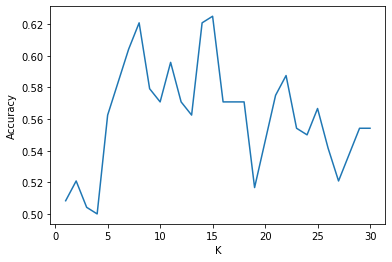

In [24]:
k_range = range(1,31)
cv_scores = []  #用来放每个模型的结果值
for n in k_range:
    knn = KNeighborsClassifier(n)   #knn模型，这里一个超参数可以做预测，当多个超参数时需要使用另一种方法GridSearchCV
    scores = cross_val_score(knn,X,Y,cv=10,scoring='accuracy')  #cv：选择每次测试折数  accuracy：评价指标是准确度,可以省略使用默认值，具体使用参考下面。
    cv_scores.append(scores.mean())
plt.plot(k_range,cv_scores)
plt.xlabel('K')
plt.ylabel('Accuracy')  #通过图像选择最好的参数
plt.show()

In [26]:
best_knn = KNeighborsClassifier(n_neighbors=10)	# 选择最优的K传入模型
best_knn.fit(X,Y)			#训练模型
print(best_knn.score(test_x,test_y))

0.21428571428571427


In [66]:
metric_all = pd.DataFrame()

from sklearn.linear_model import LogisticRegression
 
lr = LogisticRegression(C=1000, solver='liblinear', random_state=0)
metric = cross_val_score(lr, X, Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['glm'] = metric[::-1]
 
# 拟合决策树模型
from sklearn import tree
 
tree = tree.DecisionTreeClassifier(criterion='gini')
metric = cross_val_score(tree, X, Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['tree'] = metric[::-1]
 
# 拟合svm模型
from sklearn import svm
 
svc = svm.SVC(C=1.0, kernel='rbf', gamma='auto')
metric = cross_val_score(svc, X, Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['svm'] = metric[::-1]
 
# 拟合随机森林算法
from sklearn.ensemble import RandomForestClassifier
 
RF = RandomForestClassifier(n_estimators=30, criterion='gini', random_state=10)
metric = cross_val_score(RF, X, Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['RandomForest'] = metric[::-1]
 
# 构造knn最近邻模型
from sklearn import neighbors
 
knn = neighbors.KNeighborsClassifier(n_neighbors=10, algorithm='kd_tree')
metric = cross_val_score(estimator=knn, X=X, y=Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['knn'] = metric[::-1]
 
# 构造lda模型
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
 
lda = LinearDiscriminantAnalysis(solver='lsqr', shrinkage=None, priors=None)
metric = cross_val_score(estimator=lda, X=X, y=Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['lda'] = metric[::-1]
 
# 构造qda模型
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
 
qda = QuadraticDiscriminantAnalysis()
metric = cross_val_score(estimator=qda, X=X, y=Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['qda'] = metric[::-1]
 
#  高斯朴素贝叶斯,多项式贝叶斯适用于文本分类，伯努利贝叶斯需要全部变量威二值变量
from sklearn.naive_bayes import GaussianNB
 
gnb = GaussianNB()
metric = cross_val_score(estimator=gnb, X=X, y=Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['gnb'] = metric[::-1]
 
# sklearn提供了bp多层神经网络，隐含层设为 (4, 3, 2)
from sklearn.neural_network import MLPClassifier
 
mbp = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(4, 3, 2), random_state=1)
metric = cross_val_score(estimator=mbp, X=X, y=Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['mbp'] = metric[::-1]
 
# 采用adaboost算法
from sklearn.ensemble import AdaBoostClassifier
 
# 弱分类器的参数 base_estimator 默认为决策树
ada = AdaBoostClassifier(n_estimators=100)
metric = cross_val_score(estimator=ada, X=X, y=Y, cv=10, scoring='accuracy')
metric.sort()
metric_all['ada'] = metric[::-1]
 
# 将10种模型结果进行比较
print(metric_all)
print("按照F1-score进行排序")
metric_mean = metric_all.mean()
print(metric_mean.sort_values(ascending=False))

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:693: UserWarning: Variables are collinear
  warnings.warn("Variab

        glm      tree       svm  RandomForest       knn       lda       qda  \
0  1.000000  0.833333  1.000000      0.833333  1.000000  1.000000  0.666667   
1  0.750000  0.833333  0.833333      0.833333  0.833333  0.750000  0.625000   
2  0.666667  0.750000  0.750000      0.750000  0.750000  0.666667  0.500000   
3  0.666667  0.666667  0.666667      0.750000  0.666667  0.666667  0.500000   
4  0.625000  0.666667  0.625000      0.750000  0.625000  0.625000  0.500000   
5  0.625000  0.625000  0.625000      0.666667  0.625000  0.625000  0.375000   
6  0.500000  0.500000  0.500000      0.666667  0.625000  0.500000  0.375000   
7  0.500000  0.500000  0.500000      0.666667  0.500000  0.500000  0.333333   
8  0.500000  0.500000  0.500000      0.500000  0.500000  0.500000  0.333333   
9  0.375000  0.375000  0.333333      0.375000  0.500000  0.500000  0.333333   

        gnb  mbp       ada  
0  0.666667  0.5  0.833333  
1  0.666667  0.5  0.666667  
2  0.500000  0.5  0.666667  
3  0.500000  0

In [32]:
metric_all

glm      tree       svm  RandomForest       knn       lda       qda  \
0  1.000000  0.800000  1.000000      0.857143  1.000000  1.000000  0.857143   
1  0.750000  0.750000  0.857143      0.857143  0.857143  0.750000  0.857143   
2  0.750000  0.727273  0.750000      0.800000  0.800000  0.750000  0.666667   
3  0.727273  0.666667  0.666667      0.750000  0.666667  0.666667  0.666667   
4  0.666667  0.666667  0.600000      0.750000  0.600000  0.600000  0.666667   
5  0.571429  0.500000  0.600000      0.666667  0.571429  0.571429  0.571429   
6  0.571429  0.444444  0.571429      0.571429  0.444444  0.571429  0.500000   
7  0.400000  0.400000  0.500000      0.444444  0.444444  0.500000  0.285714   
8  0.285714  0.333333  0.500000      0.400000  0.333333  0.400000  0.285714   
9  0.000000  0.285714  0.333333      0.333333  0.333333  0.000000  0.000000   

        gnb       mbp       ada  
0  0.750000  0.750000  0.800000  
1  0.750000  0.750000  0.750000  
2  0.666667  0.666667  0.750000  
3  0.666667  0.571429  0.666667  
4  0.666667  0.571429  0.666667  
5  0.666667  0.571429  0.444444  
6  0.666667  0.571429  0.333333  
7  0.600000  0.250000  0.285714  
8  0.500000  0.000000  0.000000  
9  0.500000  0.000000  0.000000

In [50]:
for i in range(2,19):
    X = train_df[train_df.columns[i]].values.reshape(-1, 1)
    y = train_df['group']
    svc = svm.SVC(C=1.0, kernel='rbf', gamma='auto')
    scores = cross_val_score(svc, X, y, cv=10, scoring='accuracy')
    score = scores.mean()
    print("{}：".format(train_df.columns[i]),score)

sex： 0.5
age： 0.5125
score2： 0.575
smallbin： 0.37916666666666665
bmi： 0.6333333333333333
time_onset： 0.575
ane_diam： 0.4666666666666666
diabetes： 0.5291666666666666
hs_cad： 0.5
hyperlipidemia： 0.6208333333333333
HBP： 0.5375
SBP： 0.5583333333333333
DBP： 0.5958333333333334
ECG： 0.4125
kidney_failure： 0.4666666666666666
ln_ddimer： 0.6083333333333333
limb_ischemia： 0.4999999999999999
